<a href="https://colab.research.google.com/github/Dean-Clark27/CSE337-lab12_SAC/blob/main/Dean_Clark_CSE337_lab12_sac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12: Soft Actor Critic

Train a Soft Actor-Critic (SAC) agent on HalfCheetah-v4,
track its learning curve, and compare the result with your previous RL algorithm.

We will learn to use the **stable_baselines3** library


## To start
Run the following code that solves **the Pendulum problem**

In [1]:
# Install dependencies
!pip install "stable-baselines3[extra]" "gymnasium[classic_control]"

The following code trains a full SAC agent — with two critics, entropy tuning, and replay buffer — out of the box

In [2]:
import gymnasium as gym
from stable_baselines3 import SAC

# Create environment
env = gym.make("Pendulum-v1")

# Create SAC model
model = SAC("MlpPolicy", env, verbose=1)

# Train the agent with N time steps
N = 4000
model.learn(total_timesteps=N)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.49e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 43        |
|    time_elapsed    | 18        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 22        |
|    critic_loss     | 0.222     |
|    ent_coef        | 0.813     |
|    ent_coef_loss   | -0.321    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.44e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 38        |
|    time_elapsed    | 41        |
|    total_timesteps | 1600      |
| train/             |           |
|    actor_loss      | 46.4      |
|    critic_loss    

# Visualize the result

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gymnasium as gym
from stable_baselines3 import SAC
from IPython.display import HTML

env = gym.make("Pendulum-v1", render_mode="rgb_array")


N_steps = 500

frames = []
obs, _ = env.reset()
for _ in range(N_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    if done or truncated:
        obs, _ = env.reset()

env.close()

# Create matplotlib animation
fig = plt.figure()
img = plt.imshow(frames[0])

def animate(i):
    img.set_data(frames[i])
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)

plt.close()
HTML(ani.to_html5_video())


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

## Exercise 1: Soft Actor-Critic on HalfCheetah
**Goal:**
Adapt the existing Soft Actor-Critic (SAC) implementation from the Pendulum-v1 environment to train and evaluate a SAC agent on the more challenging HalfCheetah-v4 task.

### Instructions

1. Adapt your code: Modify your previous SAC implementation so that it runs on the HalfCheetah-v4 environment from MuJoCo.

2. Reward Logger:
Implement a custom RewardLogger callback to record episode rewards during training (you will have to search online about how to create a class for logger).
After training, use the logged data to plot the learning curve (episode reward vs. timesteps).

3. Experimentation:
    * Compare the performance of SAC on HalfCheetah-v4 with your previous algorithm.
    * Adjust the entropy temperature parameter (ent_coef or target_entropy) and observe how this affects: Exploration behavior, Convergence speed, and Final performance.

Answer the following questions
1. Did SAC reach a higher average reward or converge faster than your previous method?

2. How did changing the temperature for entropy affect the performance and stability of learning?

3. Describe any differences you observed in exploration or motion behavior of the agent.


### Deliverables

* Python notebook or script containing:
    * The adapted SAC training code
    * The RewardLogger implementation
    * Learning curve plots for SAC and your previous algorithm
    * Comparison of different entropy temperature settings

* The answer of the questions above

In [4]:
!pip install gymnasium[mujoco]

In [10]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.animation as animation
from IPython.display import HTML

class RewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLogger, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.timesteps = []
        self.current_episode_reward = 0
        self.current_episode_length = 0

    def _on_step(self) -> bool:
        """
        This method is called at every step.
        We accumulate rewards and check if episode ended.
        """
        # Accumulate reward
        self.current_episode_reward += self.locals['rewards'][0]
        self.current_episode_length += 1

        # Check if episode is done
        if self.locals['dones'][0]:
            # Log the episode data
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_lengths.append(self.current_episode_length)
            self.timesteps.append(self.num_timesteps)

            if self.verbose > 0:
                print(f"Episode: {len(self.episode_rewards)}, "
                      f"Reward: {self.current_episode_reward:.2f}, "
                      f"Length: {self.current_episode_length}, "
                      f"Timestep: {self.num_timesteps}")

            # Reset counters
            self.current_episode_reward = 0
            self.current_episode_length = 0

        return True

    def get_data(self):
      """Returns the logged data as numpy arrays"""
      return (np.array(self.timesteps),
                np.array(self.episode_rewards),
                np.array(self.episode_lengths))

  # Use Half-Cheetah Environment with SAC
env = gym.make("HalfCheetah-v4")

# Initialize reward logger
reward_logger = RewardLogger(verbose=1)


In [11]:
# Create SAC model with default settings
print("Training SAC with default entropy coefficient...")
model_default = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    buffer_size=300000,
    learning_starts=10000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    ent_coef='auto',  # Automatic entropy tuning
    tensorboard_log="./sac_halfcheetah_tensorboard/"
)

# Train the agent
N_TIMESTEPS = 100000  # Adjust based on your computational resources
model_default.learn(total_timesteps=N_TIMESTEPS, callback=reward_logger)

# Get logged data
timesteps_default, rewards_default, lengths_default = reward_logger.get_data()

# Save the model
model_default.save("sac_halfcheetah_default")

Training SAC with default entropy coefficient...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./sac_halfcheetah_tensorboard/SAC_1
Episode: 1, Reward: -279.95, Length: 1000, Timestep: 1000
Episode: 2, Reward: -237.37, Length: 1000, Timestep: 2000
Episode: 3, Reward: -339.15, Length: 1000, Timestep: 3000
Episode: 4, Reward: -304.00, Length: 1000, Timestep: 4000
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -290     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2232     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
Episode: 5, Reward: -185.23, Length: 1000, Timestep: 5000
Episode: 6, Reward: -373.91, Length: 1000, Timestep: 6000
Episode: 7, Reward: -159.91, Length: 1000, Timestep: 7000
Episode: 8, Reward: -251.47, Length: 1000, Timestep: 8000
------

In [12]:
# Higher entropy (more exploration)
print("\nTraining SAC with high entropy coefficient (0.2)...")
env_high = gym.make("HalfCheetah-v4")
reward_logger_high = RewardLogger(verbose=1)

model_high_ent = SAC(
    "MlpPolicy",
    env_high,
    verbose=1,
    ent_coef=0.2,
    learning_rate=3e-4,
    buffer_size=300000,
    learning_starts=10000,
    batch_size=256,
    tensorboard_log="./sac_halfcheetah_tensorboard/"
)

model_high_ent.learn(total_timesteps=N_TIMESTEPS, callback=reward_logger_high)
timesteps_high, rewards_high, lengths_high = reward_logger_high.get_data()
model_high_ent.save("sac_halfcheetah_high_ent")


Training SAC with high entropy coefficient (0.2)...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./sac_halfcheetah_tensorboard/SAC_2
Episode: 1, Reward: -155.35, Length: 1000, Timestep: 1000
Episode: 2, Reward: -299.49, Length: 1000, Timestep: 2000
Episode: 3, Reward: -353.42, Length: 1000, Timestep: 3000
Episode: 4, Reward: -263.42, Length: 1000, Timestep: 4000
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -268     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2202     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
Episode: 5, Reward: -176.40, Length: 1000, Timestep: 5000
Episode: 6, Reward: -252.15, Length: 1000, Timestep: 6000
Episode: 7, Reward: -347.39, Length: 1000, Timestep: 7000
Episode: 8, Reward: -408.21, Length: 1000, Timestep: 8000
--

In [13]:
# Lower entropy (less exploration, more exploitation)
print("\nTraining SAC with low entropy coefficient (0.01)...")
env_low = gym.make("HalfCheetah-v4")
reward_logger_low = RewardLogger(verbose=1)

model_low_ent = SAC(
    "MlpPolicy",
    env_low,
    verbose=1,
    ent_coef=0.01,
    learning_rate=3e-4,
    buffer_size=300000,
    learning_starts=10000,
    batch_size=256,
    tensorboard_log="./sac_halfcheetah_tensorboard/"
)

model_low_ent.learn(total_timesteps=N_TIMESTEPS, callback=reward_logger_low)
timesteps_low, rewards_low, lengths_low = reward_logger_low.get_data()
model_low_ent.save("sac_halfcheetah_low_ent")


Training SAC with low entropy coefficient (0.01)...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./sac_halfcheetah_tensorboard/SAC_3
Episode: 1, Reward: -489.44, Length: 1000, Timestep: 1000
Episode: 2, Reward: -309.01, Length: 1000, Timestep: 2000
Episode: 3, Reward: -326.62, Length: 1000, Timestep: 3000
Episode: 4, Reward: -215.56, Length: 1000, Timestep: 4000
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -335     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2212     |
|    time_elapsed    | 1        |
|    total_timesteps | 4000     |
---------------------------------
Episode: 5, Reward: -365.02, Length: 1000, Timestep: 5000
Episode: 6, Reward: -346.54, Length: 1000, Timestep: 6000
Episode: 7, Reward: -251.23, Length: 1000, Timestep: 7000
Episode: 8, Reward: -220.65, Length: 1000, Timestep: 8000
--

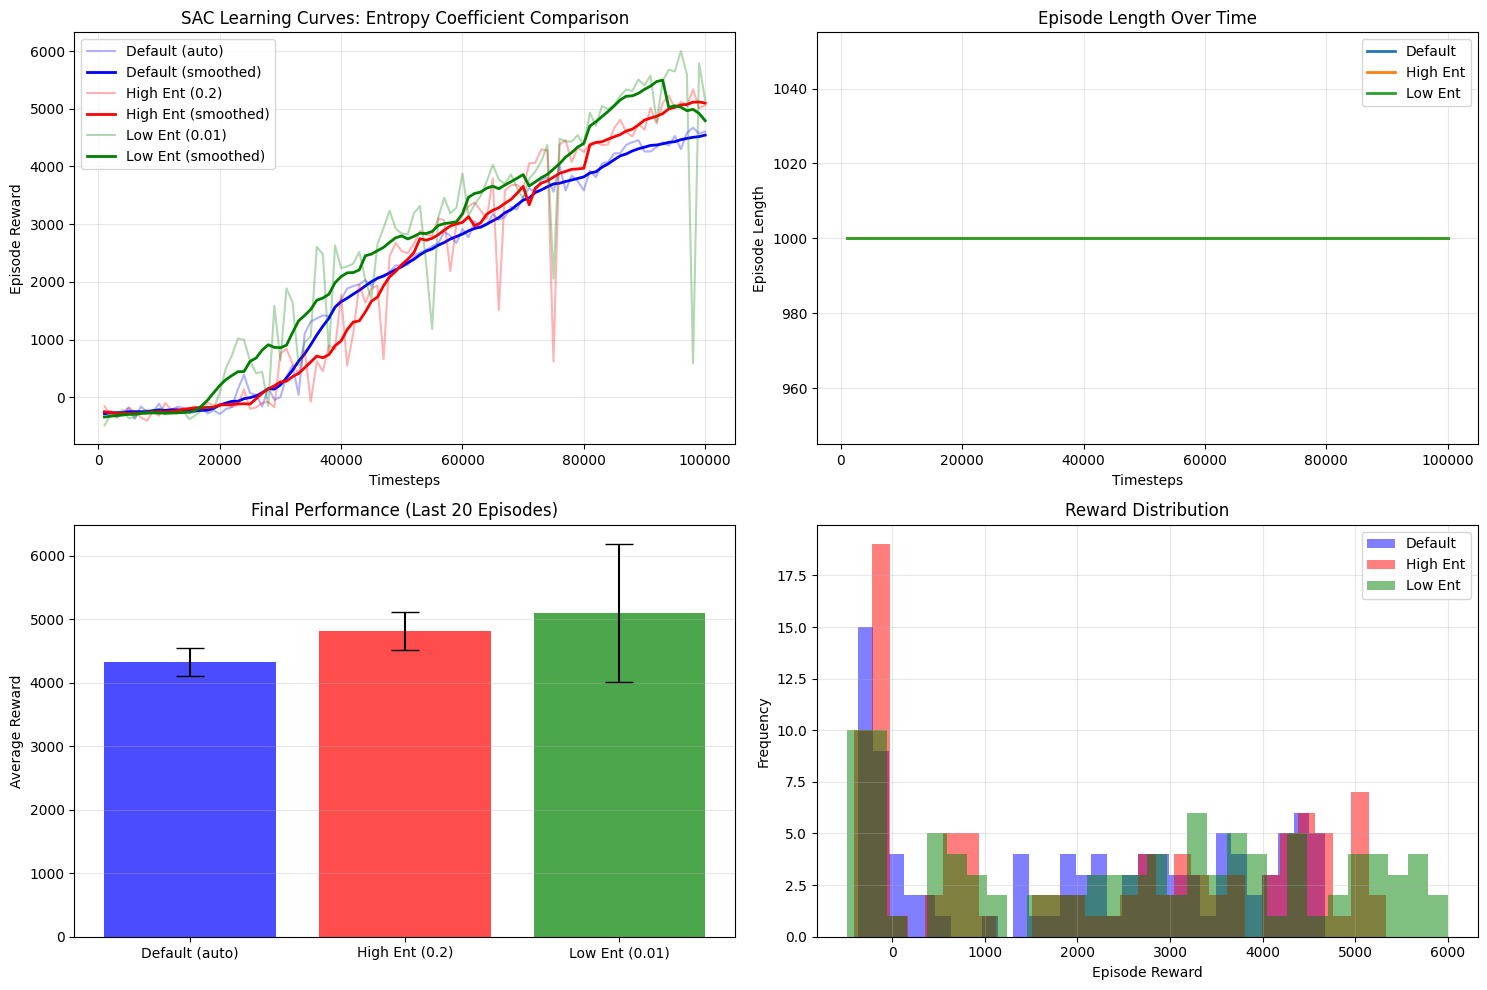

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(



TRAINING SUMMARY

Default Entropy (auto):
  Mean Reward (last 20 episodes): 4323.81 ± 222.75
  Max Reward: 4671.20

High Entropy (0.2):
  Mean Reward (last 20 episodes): 4810.08 ± 297.23
  Max Reward: 5337.54

Low Entropy (0.01):
  Mean Reward (last 20 episodes): 5090.02 ± 1085.09
  Max Reward: 6000.07

FINAL EVALUATION

Default Entropy:
  Mean Reward: 4756.71 ± 96.87
  Mean Episode Length: 1000.0

High Entropy (0.2):
  Mean Reward: 5608.88 ± 91.63
  Mean Episode Length: 1000.0

Low Entropy (0.01):
  Mean Reward: 5648.26 ± 122.00
  Mean Episode Length: 1000.0

ACTION STATISTICS ANALYSIS

Default Entropy - Action Variability (std): 0.78787106
High Entropy - Action Variability (std): 0.7258148
Low Entropy - Action Variability (std): 0.8354675

Higher std indicates more diverse actions (more exploration in behavior)


In [18]:
# Plotting Learning Curves
def moving_average(data, window_size=10):
    """Calculate moving average for smoothing"""
    if len(data) < window_size:
        return data
    # Use same mode to keep the same length as input
    smoothed = np.convolve(data, np.ones(window_size)/window_size, mode='same')
    # Fix edges by using smaller windows at the boundaries
    for i in range(window_size // 2):
        smoothed[i] = np.mean(data[:i + window_size // 2 + 1])
        smoothed[-(i+1)] = np.mean(data[-(i + window_size // 2 + 1):])
    return smoothed

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Comparison of all entropy settings
ax1 = axes[0, 0]
ax1.plot(timesteps_default, rewards_default, alpha=0.3, label='Default (auto)', color='blue')
ax1.plot(timesteps_default, moving_average(rewards_default, 10), label='Default (smoothed)', color='blue', linewidth=2)
ax1.plot(timesteps_high, rewards_high, alpha=0.3, label='High Ent (0.2)', color='red')
ax1.plot(timesteps_high, moving_average(rewards_high, 10), label='High Ent (smoothed)', color='red', linewidth=2)
ax1.plot(timesteps_low, rewards_low, alpha=0.3, label='Low Ent (0.01)', color='green')
ax1.plot(timesteps_low, moving_average(rewards_low, 10), label='Low Ent (smoothed)', color='green', linewidth=2)
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Episode Reward')
ax1.set_title('SAC Learning Curves: Entropy Coefficient Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Episode lengths
ax2 = axes[0, 1]
ax2.plot(timesteps_default, moving_average(lengths_default, 10), label='Default', linewidth=2)
ax2.plot(timesteps_high, moving_average(lengths_high, 10), label='High Ent', linewidth=2)
ax2.plot(timesteps_low, moving_average(lengths_low, 10), label='Low Ent', linewidth=2)
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Episode Length')
ax2.set_title('Episode Length Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Final performance comparison (last 20 episodes)
ax3 = axes[1, 0]
final_rewards = [
    np.mean(rewards_default[-20:]) if len(rewards_default) >= 20 else np.mean(rewards_default),
    np.mean(rewards_high[-20:]) if len(rewards_high) >= 20 else np.mean(rewards_high),
    np.mean(rewards_low[-20:]) if len(rewards_low) >= 20 else np.mean(rewards_low)
]
final_stds = [
    np.std(rewards_default[-20:]) if len(rewards_default) >= 20 else np.std(rewards_default),
    np.std(rewards_high[-20:]) if len(rewards_high) >= 20 else np.std(rewards_high),
    np.std(rewards_low[-20:]) if len(rewards_low) >= 20 else np.std(rewards_low)
]
x_pos = np.arange(len(final_rewards))
colors = ['blue', 'red', 'green']
ax3.bar(x_pos, final_rewards, yerr=final_stds, color=colors, alpha=0.7, capsize=10)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['Default (auto)', 'High Ent (0.2)', 'Low Ent (0.01)'])
ax3.set_ylabel('Average Reward')
ax3.set_title('Final Performance (Last 20 Episodes)')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Reward distribution
ax4 = axes[1, 1]
ax4.hist(rewards_default, alpha=0.5, label='Default', bins=30, color='blue')
ax4.hist(rewards_high, alpha=0.5, label='High Ent', bins=30, color='red')
ax4.hist(rewards_low, alpha=0.5, label='Low Ent', bins=30, color='green')
ax4.set_xlabel('Episode Reward')
ax4.set_ylabel('Frequency')
ax4.set_title('Reward Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sac_halfcheetah_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics

print("TRAINING SUMMARY")
print(f"\nDefault Entropy (auto):")
print(f"  Mean Reward (last 20 episodes): {np.mean(rewards_default[-20:]):.2f} ± {np.std(rewards_default[-20:]):.2f}")
print(f"  Max Reward: {np.max(rewards_default):.2f}")
print(f"\nHigh Entropy (0.2):")
print(f"  Mean Reward (last 20 episodes): {np.mean(rewards_high[-20:]):.2f} ± {np.std(rewards_high[-20:]):.2f}")
print(f"  Max Reward: {np.max(rewards_high):.2f}")
print(f"\nLow Entropy (0.01):")
print(f"  Mean Reward (last 20 episodes): {np.mean(rewards_low[-20:]):.2f} ± {np.std(rewards_low[-20:]):.2f}")
print(f"  Max Reward: {np.max(rewards_low):.2f}")

# PART 5: Evaluate Final Performance

def evaluate_agent(model, env_name="HalfCheetah-v4", n_episodes=10):
    """Evaluate the trained agent over multiple episodes"""
    env = gym.make(env_name)

    episode_rewards = []
    episode_lengths = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            episode_length += 1
            done = terminated or truncated

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

    env.close()

    return {
        'mean_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'mean_length': np.mean(episode_lengths),
        'rewards': episode_rewards
    }

print("FINAL EVALUATION")

eval_default = evaluate_agent(model_default, n_episodes=10)
eval_high = evaluate_agent(model_high_ent, n_episodes=10)
eval_low = evaluate_agent(model_low_ent, n_episodes=10)

print(f"\nDefault Entropy:")
print(f"  Mean Reward: {eval_default['mean_reward']:.2f} ± {eval_default['std_reward']:.2f}")
print(f"  Mean Episode Length: {eval_default['mean_length']:.1f}")

print(f"\nHigh Entropy (0.2):")
print(f"  Mean Reward: {eval_high['mean_reward']:.2f} ± {eval_high['std_reward']:.2f}")
print(f"  Mean Episode Length: {eval_high['mean_length']:.1f}")

print(f"\nLow Entropy (0.01):")
print(f"  Mean Reward: {eval_low['mean_reward']:.2f} ± {eval_low['std_reward']:.2f}")
print(f"  Mean Episode Length: {eval_low['mean_length']:.1f}")

# BONUS: Evaluate and Compare Action Statistics
def analyze_action_statistics(model, env_name="HalfCheetah-v4", n_steps=1000):
    """Analyze the action distribution of the trained agent"""
    env = gym.make(env_name)
    obs, _ = env.reset()

    actions_list = []

    for _ in range(n_steps):
        action, _ = model.predict(obs, deterministic=True)
        actions_list.append(action)
        obs, reward, done, truncated, info = env.step(action)

        if done or truncated:
            obs, _ = env.reset()

    env.close()
    actions_array = np.array(actions_list)

    return {
        'mean': np.mean(actions_array, axis=0),
        'std': np.std(actions_array, axis=0),
        'min': np.min(actions_array, axis=0),
        'max': np.max(actions_array, axis=0)
    }

print("ACTION STATISTICS ANALYSIS")

stats_default = analyze_action_statistics(model_default)
stats_high = analyze_action_statistics(model_high_ent)
stats_low = analyze_action_statistics(model_low_ent)

print("\nDefault Entropy - Action Variability (std):", np.mean(stats_default['std']))
print("High Entropy - Action Variability (std):", np.mean(stats_high['std']))
print("Low Entropy - Action Variability (std):", np.mean(stats_low['std']))

print("\nHigher std indicates more diverse actions (more exploration in behavior)")


### <b><u>Discussion Questions</u></b>

<b>1. Did SAC reach a higher average reward or converge faster than your previous method?</b>

Previously, we used Model-based and PETS to train the dynmaics model which would then be able to plan the actions that the model would have to make to get the HalfCheetah to be able to walk. Now, using SAC, a Model-free, off policy algorithm, it is known for being able to solve many high-dimensionality problems. Compared to other Model-free algorithms, it uses entropy regularization to balance its exploration and exploitation, and compared to PETS, was able to reach a higher average reward. This is also in part because of PETS fitting to small errors that compounded from training, as we saw in all of the dimension graphs from the HalfCheetah.   

<b>2. How did changing the temperature for entropy affect the performance and stability of learning?</b>

I tested SAC with the baseline entropy first (using auto in stable_baselines3), then trained two other models: one with a higher entropy (0.2) and one with a lower entropy (0.01). For both of these, we did not play around with 'target_entropy', which is when we want our 'ent_coef' to decay over the course of training, as we are just trying to test a fixed entropy in this case, but you could probably find better performance if you were to tune entropy for that.When we increase the entropy, it encourages the model to explore more action spaces, is considered more resilient to the agent trying to exploiting vulnerabilities in decision-making. It is the same story as changing other similar hyperparamers, meaning that this tradeoff will sacrifice some short term gains in exploitation/performance to break away from suboptimal paths. Lower entropy will in general allow for greater shroter term performance, but will not be able to explore and get stuck in a suboptimal path. In this situation, the low entropy worked the best up until around 85,000-90,000 episodes, but then the high entropy pulled away because of an unexpected dip.   

<b>3. Describe any differences you observed in exploration or motion behavior of the agent.</b>

For high entropy, the movements are less smooth, but are more optimal, whereas for small entropy, the movements are more smooth but less optimal. You can look at how it sort of hops, gallops, and runs, it wobbles at times, moves forward at different speeds, moves a bit awkwardly with 4 legs, and can fall in many episodes. Again, this matches what we explain above in relation to exploration vs. exploitation.